In [39]:
import pandas as pd
import csv
import numpy as np

from random import random
from keras.models import Sequential
from keras.layers.core import TimeDistributedDense, Activation
from keras.layers.recurrent import LSTM

data = pd.read_csv('khan100000_clean.csv')

In [40]:
# problems = data.copy()
problems = pd.DataFrame()
problems.insert(0, 'false', np.zeros(len(data), dtype=np.int))
problems.insert(1, 'true', np.zeros(len(data), dtype=np.int))

# problems = problems.drop(['problem_correct','problem_backup_timestamp','problem_time_taken','problem_exercise', \
# 					'problem_problem_type','problem_seed', 'problem_sha1','problem_hint_used','attempts'], 1)
# drop index and users
# print problems.columns.values

In [41]:
# Creating a set for all excercises
skill_col = data['problem_exercise']
skills = set()
for skill in skill_col:
    if skill not in skills:
        skills.add(skill)

for skill in skills:
    problems[skill] = 0  
    
# print len(problems.columns.values)

In [42]:
added_rows = 0
past_student = None
new = 0

new_row = np.zeros(len(skills)+2, dtype=np.int)

for i, row in enumerate(data.values): 
    if row[0] != past_student:
        new += 1
        problems.loc[i+added_rows] = new_row
        problems.loc[len(problems)] = new_row
        added_rows += 1
        past_student = row[0]
    if row[1]:         
        problems['true'].iloc[i + added_rows] = 1
    else:
        problems['false'].iloc[i + added_rows] = 1
    for skill in skills:
        if row[4] == skill:
            problems[skill].iloc[i + added_rows] = 1

In [148]:
# added_rows = 0
# past_student = None
# new = 0

# new_row = np.zeros(len(skills)+2, dtype=np.int)

# for i, row in enumerate(data.values): 
#     if row[0] != past_student and past_student:
#         new += 1
#         problems.loc[i+added_rows] = new_row
#         problems.loc[len(problems)] = new_row
#         added_rows += 1
#     past_student = row[0]
#     if row[1]:         
#         problems['true'].iloc[i + added_rows] = 1
#     else:
#         problems['false'].iloc[i + added_rows] = 1
#     for skill in skills:
#         if row[4] == skill:
#             problems[skill].iloc[i + added_rows] = 1

In [44]:
labels = problems.iloc[1:].copy()
labels.loc[len(labels)] = np.zeros(len(skills)+2, dtype=np.int)


def _load_data(data, n_prev = 100):
    """
    data should be pd.DataFrame()
    """
    docX, docY = [], []
    for i in range(0, len(data)-n_prev, 100):
        docX.append(data.iloc[i:i+n_prev-1].as_matrix())
        docY.append(data.iloc[i+1:i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def train_test_split(data):
    """
    This just splits data to training and testing parts
    """
    ntrn = int(round(len(data) * 0.8))

    train, train_labels = _load_data(data.iloc[0:ntrn])
    test, test_labels = _load_data(data.iloc[ntrn:])

    return (train, train_labels), (test, test_labels)

(train, train_labels), (test, test_labels) = train_test_split(problems)

print train.shape
print train_labels.shape

(114, 99, 316)
(114, 99, 316)


In [162]:
# labels = problems.iloc[1:].copy()
# labels.loc[len(labels)] = np.zeros(len(skills)+2, dtype=np.int)

# def _load_data(data, n_prev = 10):
#     """
#     data should be pd.DataFrame()
#     """
#     docX, docY = [], []
#     for i in range(len(data)-n_prev):
#         window = np.array()
#         for j in range(i,i+n_prev):
#             if not data.iloc[j][0] and not data.iloc[j][0]:
                
#             docX.append(data.iloc[i:i+n_prev].as_matrix())
#         docY.append(data.iloc[i+1:i+n_prev+1].as_matrix())
#     alsX = np.array(docX)
#     alsY = np.array(docY)

#     return alsX, alsY

# def train_test_split(data):
#     """
#     This just splits data to training and testing parts
#     """
#     ntrn = int(round(len(data) * 0.8))

#     train, train_labels = _load_data(data.iloc[0:ntrn])
#     test, test_labels = _load_data(data.iloc[ntrn:])

#     return (train, train_labels), (test, test_labels)

# (train, train_labels), (test, test_labels) = train_test_split(problems)

# print test.shape
# print test_labels.shape

0
(195, 10, 110)
(195, 10, 110)


In [46]:
in_neurons = 316
out_neurons = 316
hidden_neurons = 256

model = Sequential()
model.add(LSTM(output_dim=hidden_neurons, input_dim=in_neurons, return_sequences=True))
model.add(TimeDistributedDense(output_dim=out_neurons, input_dim=hidden_neurons))
model.add(Activation("linear"))
model.compile(loss="mean_squared_error", optimizer="rmsprop")

model.fit(train, train_labels, batch_size=50, nb_epoch=1)

Epoch 1/1
114/114 [==============================] - 22s - loss: 0.0170


In [16]:
# predicted = model.predict(test)
# rmse = np.sqrt(((predicted - test_labels) ** 2).mean(axis=0))

# pd.DataFrame(predicted[:100]).to_csv("predicted.csv")
# pd.DataFrame(test_labels[:100]).to_csv("test_data.csv")

In [47]:
# weights = model.layers[0].get_weights()
# test_row = np.array([[problems.values[0]]])
# eval = model.predict(np.array([train[0]]))
# weights = model.get_weights()
# print len(weights)
model2 = Sequential()
model2.add(LSTM(output_dim=hidden_neurons, input_dim=in_neurons, return_sequences=True, weights=model.layers[0].get_weights()))
model2.add(Activation('tanh'))
model2.compile(loss="mean_squared_error", optimizer="rmsprop")

# Check for correct hidden layer
# activations = model2.predict(np.array([train[0]]))
# print activations.shape

In [48]:
# Creates a dictionary with Key = Unique Students and Values = Student's Data

all_students = dict()
timesteps = []
index = 0
for row in problems.values:
    if row[0] == 0 and row[1] == 0:
        timesteps = []
        all_students[index+1] = timesteps
        index += 1
    else:
        all_students[index].append(row)



In [49]:
# Creates a dictionary with Key = Unique Students and Values = Student's Hidden Data

predictions = dict()
first = []

for index in all_students:
    for row in all_students[index]:
        if index not in predictions:
            first = []
            predictions[index] = first
        else:
            temp = np.array([[row]])
            predict = model2.predict(temp)
            # Check for correct hidden output state
#             print predict.shape
            predictions[index].append(predict)


In [ ]:
# only_first = []
# middle = []
# last = []

# for student in predictions:
#     if predictions[student]:
#         only_first.append(predictions[student][0][0])
#         middle.append(student_at_first[student][len(student_at_first[student]) / 2])
#         last.append(student_at_first[student][len(student_at_first[student]) - 1])

# print len(only_first)
# np.savetxt("only_first.txt", np.array(only_first))
# np.savetxt("middle.txt", np.array(only_first))
# np.savetxt("last.txt", np.array(only_first))

In [50]:
all_timesteps = []
for student in predictions:
    if predictions[student]:
        for hiddens in predictions[student]:
            all_timesteps.append(hiddens[0][0])

np.savetxt("test.txt", np.array(all_timesteps))

In [ ]:
% run tsne.py

X = Math.loadtxt("test.txt");
Y = tsne(X, 2, 316, 20.0);

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  14058 ...
Computing P-values for point  100  of  14058 ...
Computing P-values for point  200  of  14058 ...
Computing P-values for point  300  of  14058 ...
Computing P-values for point  400  of  14058 ...
Computing P-values for point  500  of  14058 ...
Computing P-values for point  600  of  14058 ...
Computing P-values for point  700  of  14058 ...
Computing P-values for point  800  of  14058 ...
Computing P-values for point  900  of  14058 ...
Computing P-values for point  1000  of  14058 ...
Computing P-values for point  1100  of  14058 ...
Computing P-values for point  1200  of  14058 ...
Computing P-values for point  1300  of  14058 ...
Computing P-values for point  1400  of  14058 ...
Computing P-values for point  1500  of  14058 ...
Computing P-values for point  1600  of  14058 ...
Computing P-values for point  1700  of  14058 ...
Computing P-values for point  1800  of  1405

In [52]:
import matplotlib.pylab as plt
import sklearn.cluster as sk

# colors = ['red','green','blue','yellow','orange']
# plt.figure(figsize=(10,10))

# timestep = Y[::99]
# print first

for timestep in range(99):
    timestep = Y[timestep::99]
#     kmeans = sk.KMeans(n_clusters = 5)
#     kmeans.fit(Y)

#     memb = Math.array(kmeans.labels_)

#     for i in range(5):
#         ind = Math.where(memb==i)
#         Plot.scatter(Y[ind,0], Y[ind,1], 100, colors[i], alpha = 0.2)
#     Plot.savefig(timestep + '.jpg')


print len(Y) 

NameError: name 'Y' is not defined

In [166]:
%matplotlib inline
import matplotlib.pylab as plt
import sklearn.cluster as sk

kmeans = sk.KMeans(n_clusters = 5)
kmeans.fit(Y)

centers = map(float, kmeans.labels_)


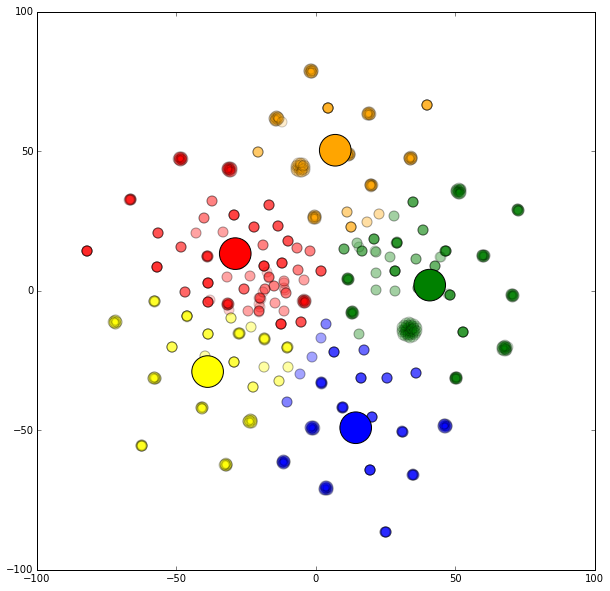

In [167]:
kc = kmeans.cluster_centers_

memb = Math.array(kmeans.labels_)

colors = ['red','green','blue','yellow','orange']
plt.figure(figsize=(10,10))
for i in range(5):
    ind = Math.where(memb==i)
    Plot.scatter(Y[ind,0], Y[ind,1], 100, colors[i], alpha = 0.2)
Plot.scatter(kc[:,0], kc[:,1], 1000, colors)